# ***Regresyon Projesi***

## ***Ev Fiyatlari***

Veri seti [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)'dan elde edilmistir.

***Proje Adimlari***

- Kesifsel veri analizi adimlari (veri temizligi, veri kesfi ve ozellik muhendisligi) [burada](https://github.com/ahmetpergamum/datascience/blob/master/07_regression_project/eda_house_prices.ipynb) yapilmis, outlier temizligi [burada](https://github.com/ahmetpergamum/datascience/blob/master/07_regression_project/outlier_cleaning.ipynb) yapilmis, gerektiginde bu adimlar tekrarlanmistir.

- Veriler eğitim ve test kümelerine ayrilmistir. Verilerin %20 si rasgele secilerek test kumesi olusturulmustur.

- Açıklayıcı değişken olarak seçtiğimiz değişkenleri kullanarak bir regresyon modeli tahmin edilmistir.
    - Modelin lineer regresyon varsayimlarini karsilama durumuna bakilmistir. Karsilanmayan varsayimlar varsa model iyilestirilmeye calisilmistir.
    - Denenen değişik modellerden en iyisi olduğu dusunulen model secilmistir. 

- Secilen model ile test kümesindeki veriler kullanarak tahmin yapilmis, tahmin performansi RMSE gibi metrikleri kullanilarak sayisal olarak değerlendirilmistir. Tahmin edilen değerler ile gerçek değerler bir grafik üzerinde cizdirilerek model analiz edilmisitir.
---

In [10]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set(style="whitegrid")
# lineer regresyon icin
from sklearn import linear_model
import statsmodels.api as sm
# polynomial features icin
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# regularizasyon icin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# path ile calismak icin
import sys
# dosyanin bulundugu dizini path e ekledik
mylib = '/home/admin1/datascience/datascience/library'
if mylib not in sys.path:
    sys.path.insert(1, mylib)
# parser i kullanabilmek icin
from data_description_parser import data_description_house_prices
data_dict = data_description_house_prices()

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}

# temiz veri setini dataframe icerisine yukle
house_prices = pd.read_csv('data/house_prices_out.csv',index_col='Id')

# object tipinde olanlar kategorik degiskenler listesine ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olanlar kategorik degiskenler listesine ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

- Sonuclar dataframe olusturularak kaydedilecek.

In [11]:
# performans sonuclarini tutacak df
results_df = pd.DataFrame(columns=['description', 'rsquared_train', 'rsquared_test', 
                                   'MAE', 'MSE', 'RMSE', 'MAPE'])
results_df.index.name = 'model' 

# tahmin sonuclarini tutacak dataframe
predict_df = pd.DataFrame(columns=['model_nu', 'real_value', 'prediction_value', 
                                   'type', 'description'])

- Fonksiyon tanimlamalari

In [12]:
# sonuclari kaydeden fonksiyon scikit learn icin
def save_results(regression, model_nu, x_train, x_test, y_train, y_test, y_test_pred, description):
    # global degiskeni degistirmek istiyorsak fonksiyon icersinde bu tanimlama olmali
    global results_df
    new = 0
    # model_nu varsa ustune yaz yoksa yeni olustur concat et
    if ((results_df.index == model_nu).any()):
        df = results_df
    else:
        df = pd.DataFrame([])
        df.index.name = 'model'
        new = 1
    df.loc[model_nu,'description'] = description
    df.loc[model_nu,'rsquared_train'] = regression.score(x_train, y_train)
    df.loc[model_nu,'rsquared_test'] = regression.score(x_test, y_test)
    df.loc[model_nu,'MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc[model_nu,'MSE'] = mse(y_test, y_test_pred)
    df.loc[model_nu,'RMSE'] = rmse(y_test, y_test_pred)
    df.loc[model_nu,'MAPE'] = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100   
    
    if new == 1:        
        results_df = pd.concat([results_df, df])

# tahmin sonuclarini kaydeden fonksiyon
def save_pred_results(model_nu, y_test, y_test_pred, y_train, y_train_pred, description):
    # global degiskeni degistirmek istiyorsak fonksiyon icersinde bu tanimlama olmali
    global predict_df    
    train_nu = y_train.shape[0]
    test_nu = y_test.shape[0]
    row_nu = train_nu + test_nu
    # model_nu yoksa yeni olustur concat et
    if not ((predict_df.model_nu == model_nu).any()):       
        df = pd.DataFrame([])
        df['model_nu'] = [model_nu for i in range(row_nu)]
        df['description'] = [description for i in range(row_nu)]       
        df['type'] = ['train'  if i<train_nu else 'test' for i in range(row_nu)]
        # series oldugundan degerleri array seklinde almak icin .values kullandik
        df.loc[df['type']=='train', 'real_value'] = y_train.values
        df.loc[df['type']=='train', 'prediction_value'] = y_train_pred  
        # series oldugundan degerleri array seklinde almak icin .values kullandik
        df.loc[df['type']=='test', 'real_value'] = y_test.values
        df.loc[df['type']=='test', 'prediction_value'] = y_test_pred
        predict_df = pd.concat([predict_df, df])
        

# plotly ile model performans grafigi
def make_plotly(df, model_nu):
    # gercek deger - tahmin degeri grafigi
    fig = px.scatter(df, x=df.loc[df['model_nu']==model_nu, 'real_value'], 
                     y=df.loc[df['model_nu']==model_nu, 'prediction_value'], 
                     color=df.loc[df['model_nu']==model_nu, 'type'])
    # gercek deger dogrusu
    fig.add_trace(go.Scatter(x=df.loc[df['model_nu']==model_nu, 'real_value'], 
                             y=df.loc[df['model_nu']==model_nu, 'real_value'], 
                             mode='lines', name='real_line', opacity=0.5)) 
    # rmse hesaplama
    rmse_model = rmse(df.loc[(df['model_nu']==model_nu) & (df['type']=='test'), 'real_value'],
                      df.loc[(df['model_nu']==model_nu) & (df['type']=='test'),
                             'prediction_value'])
    # plotly nin varsayilan parametreleri yerine daha okunakli olmasi icin
    # genislik yukseklik degerleri
    fig.update_layout(width=1200,  height=600, title_text='Model Performance')
    # rmse degerini grafige yazma
    fig.add_annotation(x=500000, y=100000, text="RMSE : {:.2f}".format(rmse_model))
    #fig.update_xaxes(range=[1000, 760000])
    #fig.update_yaxes(range=[1000, 760000])
    fig.show()
        
        
# matplotlib kullanilarak tahmin ve gercek deger grafigini cizdiren fonksiyon   
def make_plot(y_test, y_test_pred, y_train, y_train_pred):   
    plt.figure(dpi = 100)
    # gercek degerler ve tahmin degerleri
    # egitim tahminleri
    plt.scatter(y_train, y_train_pred, label='train')
    # test tahminleri
    plt.scatter(y_test, y_test_pred, label='test', alpha=0.7)
    # gercek degerlerin cizgisi
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("Gerçek Değerler", fontdict=axis_font)
    plt.ylabel("Tahmin edilen Değerler", fontdict=axis_font)
    # rmse degerlerini annotate ile grafige yazabiliriz
    plt.annotate('RMSE test  : {:.2f}'.format(rmse(y_test,y_test_pred)), xy=(600000,200000))
    plt.annotate('RMSE train : {:.2f}'.format(rmse(y_train,y_train_pred)), xy=(600000,100000))
    plt.title("Satis Fiyati: Gerçek ve tahmin edilen değerler", fontdict=title_font)
    # legend lokasyonunu belirler
    plt.legend(loc='upper left')
    plt.show()

# kategorik degiskenleri encode eden fonksiyon
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o

In [13]:
qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')
expl_vars = []
expl_vars = quantitative + qual_encoded

print('Min satis fiyati : {}\nMax satis fiyati : {}'.format(house_prices['SalePrice'].min(),
                                                            house_prices['SalePrice'].max()))

print('Aciklayici degisken adedi : {}'.format(len(expl_vars)))


Min satis fiyati : 34900
Max satis fiyati : 485000
Aciklayici degisken adedi : 79


In [14]:
# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()


In [15]:
vars_to_remove = []
# p degerleri yuksek olanlari cikar
for var in expl_vars:
    if results.pvalues[var]>0.05:
        vars_to_remove.append(var)
        
# istenmeyenleri ayir
for var in vars_to_remove:
    if var in expl_vars:
        expl_vars.remove(var) 

In [16]:
expl_vars.remove('Utilities_E')
expl_vars.remove('PoolQC_E')

len(expl_vars)

32

### ***1. Model - Butun Anlamli Degiskenlerle***

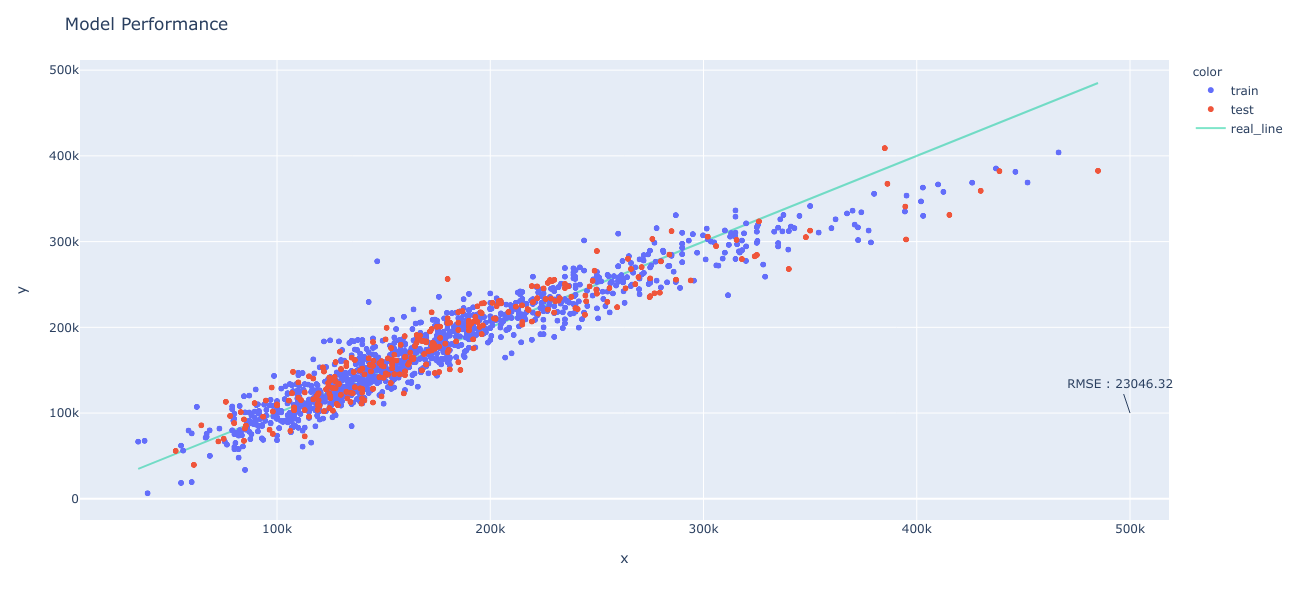

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090


In [17]:
# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

#print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape))
#print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

save_pred_results(1, Y_test, Y_test_pred, Y_train, Y_train_pred, 'butun anlamli degiskenler')

# grafigi cizdirelim
make_plotly(predict_df, 1)
#predict_df.info()

# model sonuclarini kaydedelim
save_results(lrm, 1, X_train, X_test, Y_train, Y_test, Y_test_pred, 'butun anlamli degiskenler')

# model sonuclari
results_df

### ***2.Model - Polynomial Butun Anlamli Degiskenlerle***

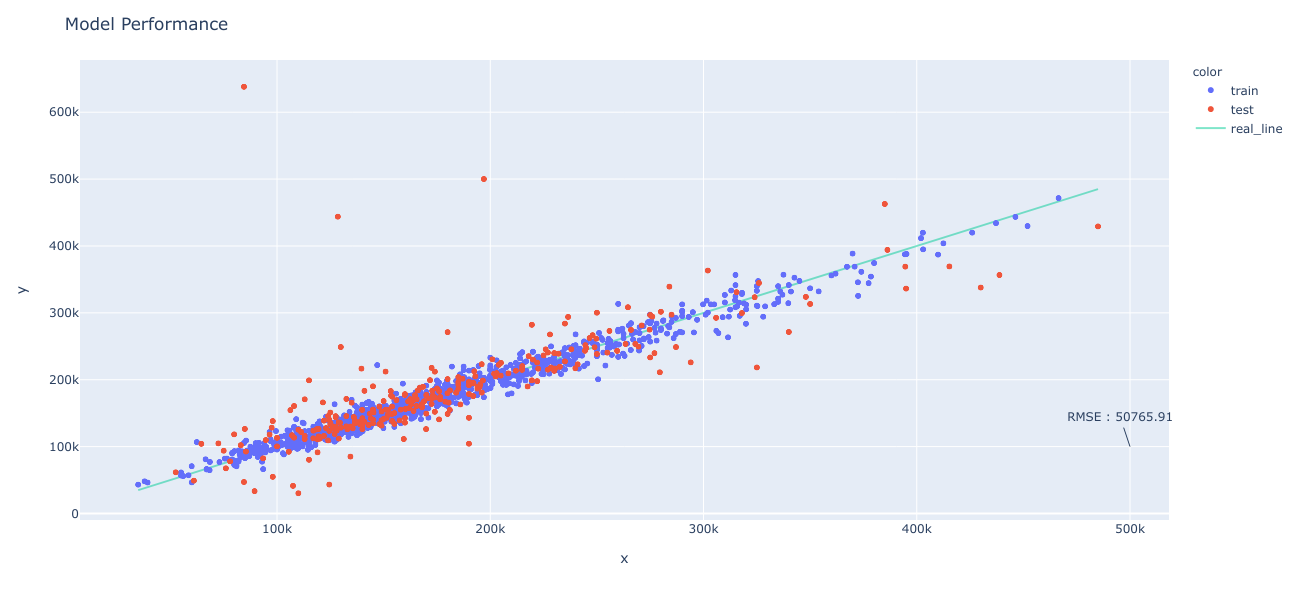

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090
2,polynomial butun anlamli degiskenler,0.970,0.484,"23,524.834","2,577,177,233.397","50,765.906",15.609


In [18]:
# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# kacinci dereceden polinomlar olusturacagiz belirtiyoruz
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

#print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape))
#print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

save_pred_results(2, Y_test, Y_test_pred, Y_train, Y_train_pred,
                  'polynomial butun anlamli degiskenler')

# grafigi cizdirelim
make_plotly(predict_df, 2)

# model sonuclarini kaydedelim
save_results(lrm, 2, X_train, X_test, Y_train, Y_test, Y_test_pred, 
             'polynomial butun anlamli degiskenler')

# model sonuclari
results_df

### ***3. Model (Polynomial butun anlamli degiskenlerle - Ridge)***

In [322]:
# en iyi alpha degerini bulmak icin dongu
rmse_best = 50000
alpha_best = 1
for alpha in range(1090000980,1090000991,10):        
    # ridge regresyonu
    ridgeregr = Ridge(alpha=alpha) 
    ridgeregr.fit(X_train, Y_train)
    # test thamini
    Y_test_pred = ridgeregr.predict(X_test)
    rmse_new = rmse(Y_test, Y_test_pred)
    
    if rmse_new < rmse_best:
        rmse_best = rmse_new
        alpha_best = alpha
        
print('En iyi alpha degeri: {}\nRMSE degeri: {:.2f}'.format(alpha_best, rmse_best))

En iyi alpha degeri: 1090000990
RMSE degeri: 20944.90


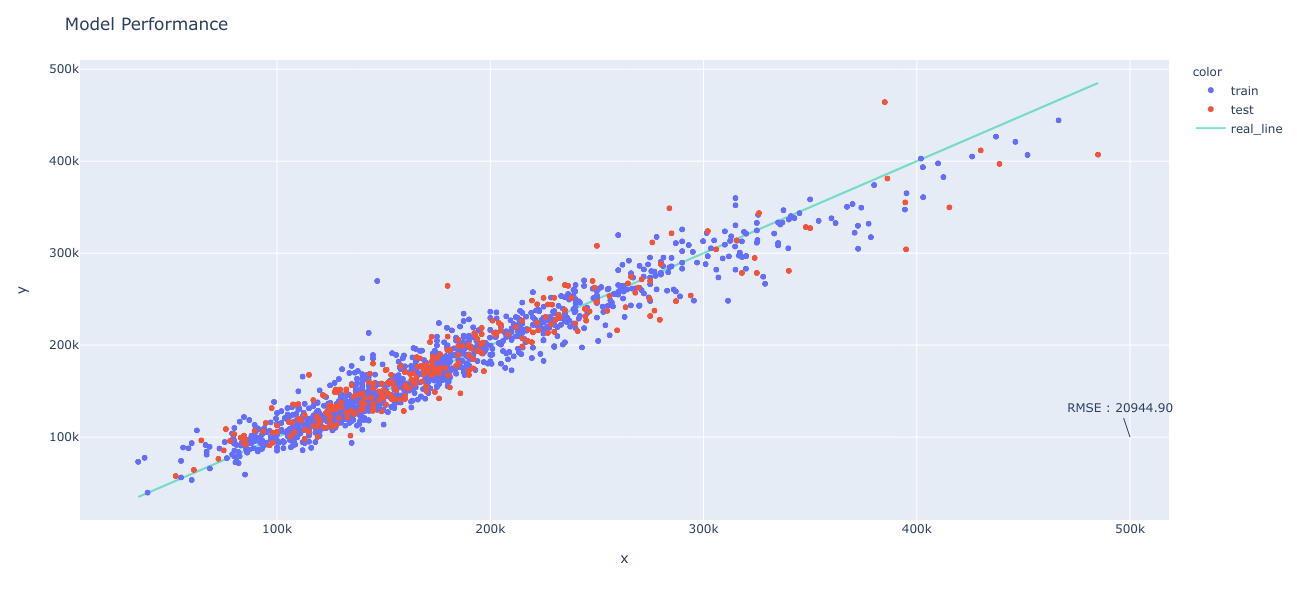

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090
2,polynomial butun anlamli degiskenler,0.970,0.484,"23,524.834","2,577,177,233.397","50,765.906",15.609
3,polynomial butun anlamli degiskenlerle - ridge,0.941,0.912,"14,996.886","438,688,953.266","20,944.903",8.575


In [19]:
# ridge regresyonu
ridgeregr = Ridge(alpha=1090000990) 
ridgeregr.fit(X_train, Y_train)

# test thamini
Y_test_pred = ridgeregr.predict(X_test)
# train thamini
Y_train_pred = ridgeregr.predict(X_train)

save_pred_results(3, Y_test, Y_test_pred, Y_train, Y_train_pred,
                  'polynomial butun anlamli degiskenler - ridge')


# grafigi cizdirelim
make_plotly(predict_df, 3)

# model sonuclarini kaydedelim
save_results(ridgeregr, 3, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'polynomial butun anlamli degiskenlerle - ridge')

# model sonuclari
results_df


### ***4. Model (Polynomial butun anlamli degiskenlerle - Lasso)***

In [324]:
# en iyi alpha degerini bulmak icin dongu
rmse_best = 50000
alpha_best = 1
for alpha in range(1100090,1100096,5):        
    # ridge regresyonu
    lassoregr = Lasso(alpha=alpha) 
    lassoregr.fit(X_train, Y_train)
    # test thamini
    Y_test_pred = lassoregr.predict(X_test)
    rmse_new = rmse(Y_test, Y_test_pred)
    
    if rmse_new < rmse_best:
        rmse_best = rmse_new
        alpha_best = alpha
        
print('En iyi alpha degeri: {}\nRMSE degeri: {:.2f}'.format(alpha_best, rmse_best))

En iyi alpha degeri: 1100095
RMSE degeri: 20638.35


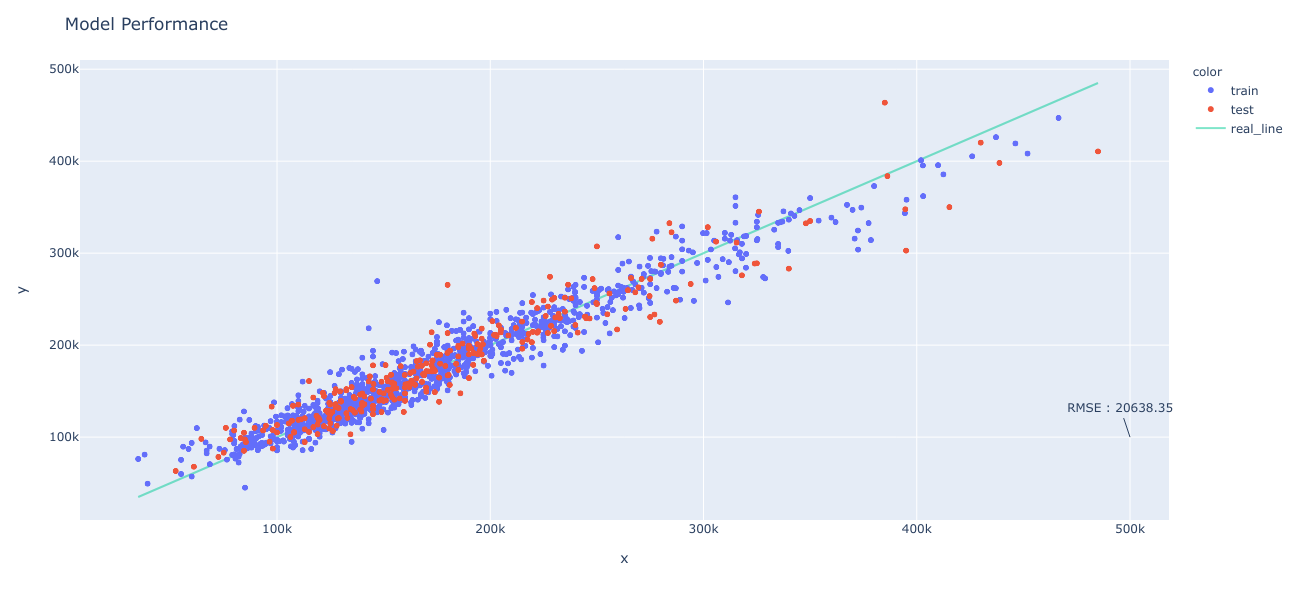

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090
2,polynomial butun anlamli degiskenler,0.970,0.484,"23,524.834","2,577,177,233.397","50,765.906",15.609
3,polynomial butun anlamli degiskenlerle - ridge,0.941,0.912,"14,996.886","438,688,953.266","20,944.903",8.575
4,polynomial butun anlamli degiskenlerle - lasso,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520


In [20]:
# lasso regresyonu
lassoregr = Lasso(alpha=1100095) 
lassoregr.fit(X_train, Y_train)

# test thamini
Y_test_pred = lassoregr.predict(X_test)
# train thamini
Y_train_pred = lassoregr.predict(X_train)

save_pred_results(4, Y_test, Y_test_pred, Y_train, Y_train_pred,
                  'polynomial butun anlamli degiskenler - lasso')

# grafigi cizdirelim
make_plotly(predict_df, 4)

# model sonuclarini kaydedelim
save_results(lassoregr, 4, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'polynomial butun anlamli degiskenlerle - lasso')

# model sonuclari
results_df


### ***5. Model (Polynomial butun anlamli degiskenlerle - ElasticNet)***

In [326]:
# en iyi alpha, l1_ratio degerini bulmak icin dongu
rmse_best = 50000
alpha_best = 1
l1_ratio_best = 0.1
for l1_ratio in np.arange(1,1.5,0.5):
    for alpha in range(20,30,1):        
        # ridge regresyonu
        elasticregr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio) 
        elasticregr.fit(X_train, Y_train)
        # test thamini
        Y_test_pred = elasticregr.predict(X_test)
        rmse_new = rmse(Y_test, Y_test_pred)

        if rmse_new < rmse_best:
            rmse_best = rmse_new
            alpha_best = alpha
            l1_ratio_best = l1_ratio
        
print('En iyi alpha degeri : {}\nEn iyi l1_ratio degeri: {}\nRMSE : {:.2f}'.format(alpha_best, 
                                                                    l1_ratio_best, rmse_best))

En iyi alpha degeri : 29
En iyi l1_ratio degeri: 1.0
RMSE : 23652.61


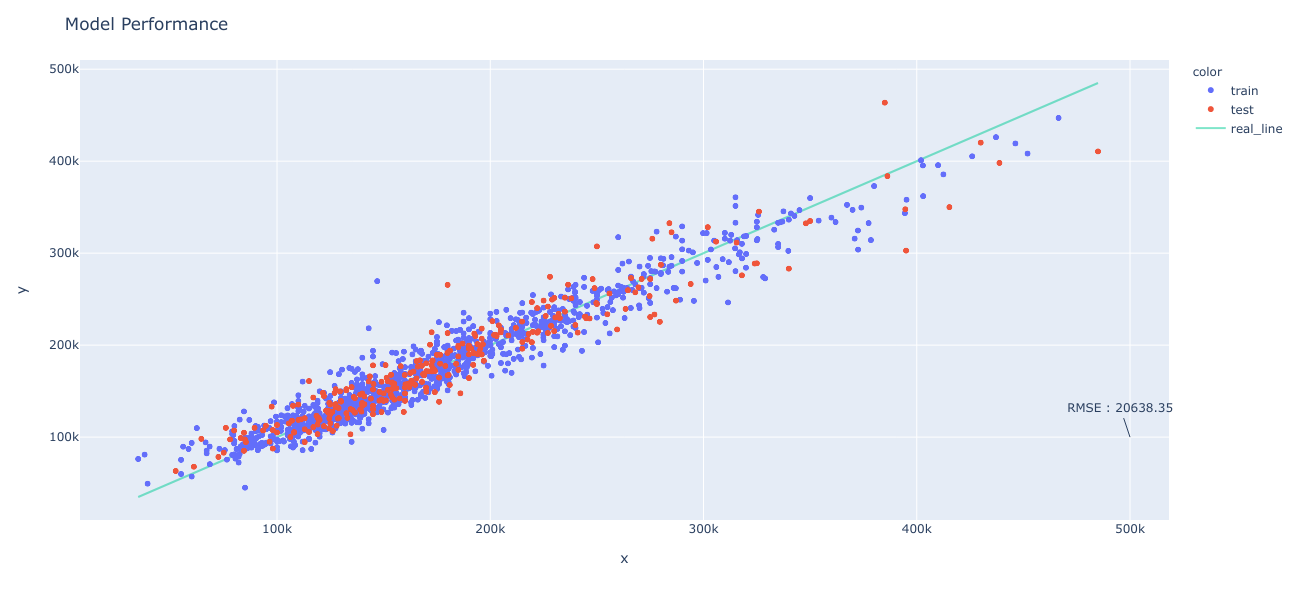

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090
2,polynomial butun anlamli degiskenler,0.970,0.484,"23,524.834","2,577,177,233.397","50,765.906",15.609
3,polynomial butun anlamli degiskenlerle - ridge,0.941,0.912,"14,996.886","438,688,953.266","20,944.903",8.575
4,polynomial butun anlamli degiskenlerle - lasso,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520
5,polynomial butun anlamli degiskenlerle - elasticnet,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520


In [21]:
# elasticnet regresyonu
elasticregr = ElasticNet(alpha=1100095, l1_ratio=1.0) 
elasticregr.fit(X_train, Y_train)

# test thamini
Y_test_pred = elasticregr.predict(X_test)
# train thamini
Y_train_pred = elasticregr.predict(X_train)

save_pred_results(5, Y_test, Y_test_pred, Y_train, Y_train_pred,
                  'polynomial butun anlamli degiskenler - elasticnet')

# grafigi cizdirelim
make_plotly(predict_df, 5)


# model sonuclarini kaydedelim
save_results(elasticregr, 5, X_train, X_test, Y_train, Y_test, Y_test_pred,
             'polynomial butun anlamli degiskenlerle - elasticnet')

# model sonuclari
results_df


### ***6.Model - Yuksek Korelasyonlularla***

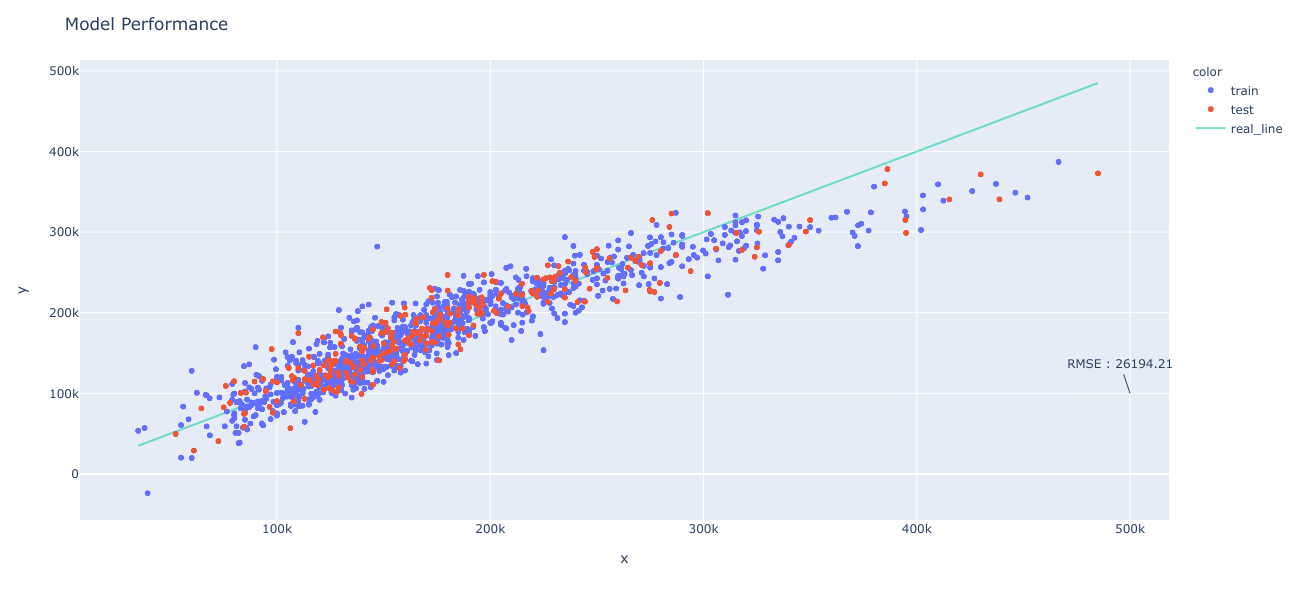

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090
2,polynomial butun anlamli degiskenler,0.970,0.484,"23,524.834","2,577,177,233.397","50,765.906",15.609
3,polynomial butun anlamli degiskenlerle - ridge,0.941,0.912,"14,996.886","438,688,953.266","20,944.903",8.575
4,polynomial butun anlamli degiskenlerle - lasso,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520
5,polynomial butun anlamli degiskenlerle - elasticnet,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520
6,yuksek korelasyonlular,0.869,0.863,"19,599.467","686,136,629.998","26,194.210",11.598


In [22]:
# korelasyon matrisi
corr_matrix = house_prices[quantitative+qual_encoded+['SalePrice']].corr()

# hedef degisken korelasyonuna gore siraladik
sale_price_corr = corr_matrix['SalePrice'].sort_values()
# hedef degiskenimizi (SalePrice) cikardik
sale_price_corr.drop('SalePrice', inplace= True)

# korealsyon mutlak degeri 0.5 den yuksek olanlar
sale_price_corr = np.abs(sale_price_corr)
high_corr = [var for var in sale_price_corr.index if sale_price_corr[var] > 0.5]

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[high_corr]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

#print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape))
#print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

save_pred_results(6, Y_test, Y_test_pred, Y_train, Y_train_pred, 'yuksek korelasyonlular')

# grafigi cizdirelim
make_plotly(predict_df, 6)
#predict_df.info()

# model sonuclarini kaydedelim
save_results(lrm, 6, X_train, X_test, Y_train, Y_test, Y_test_pred, 
             'yuksek korelasyonlular')

# model sonuclari
results_df

---
### ***Model Karsilastirma Grafigi***
- Iki ya da daha fazla modelin grafigi.

,description,rsquared_train,rsquared_test,MAE,MSE,RMSE,MAPE
model,,,,,,,
1,butun anlamli degiskenler,0.911,0.894,"17,394.021","531,133,085.037","23,046.325",10.090
2,polynomial butun anlamli degiskenler,0.970,0.484,"23,524.834","2,577,177,233.397","50,765.906",15.609
3,polynomial butun anlamli degiskenlerle - ridge,0.941,0.912,"14,996.886","438,688,953.266","20,944.903",8.575
4,polynomial butun anlamli degiskenlerle - lasso,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520
5,polynomial butun anlamli degiskenlerle - elasticnet,0.938,0.915,"14,739.549","425,941,439.899","20,638.349",8.520
6,yuksek korelasyonlular,0.869,0.863,"19,599.467","686,136,629.998","26,194.210",11.598


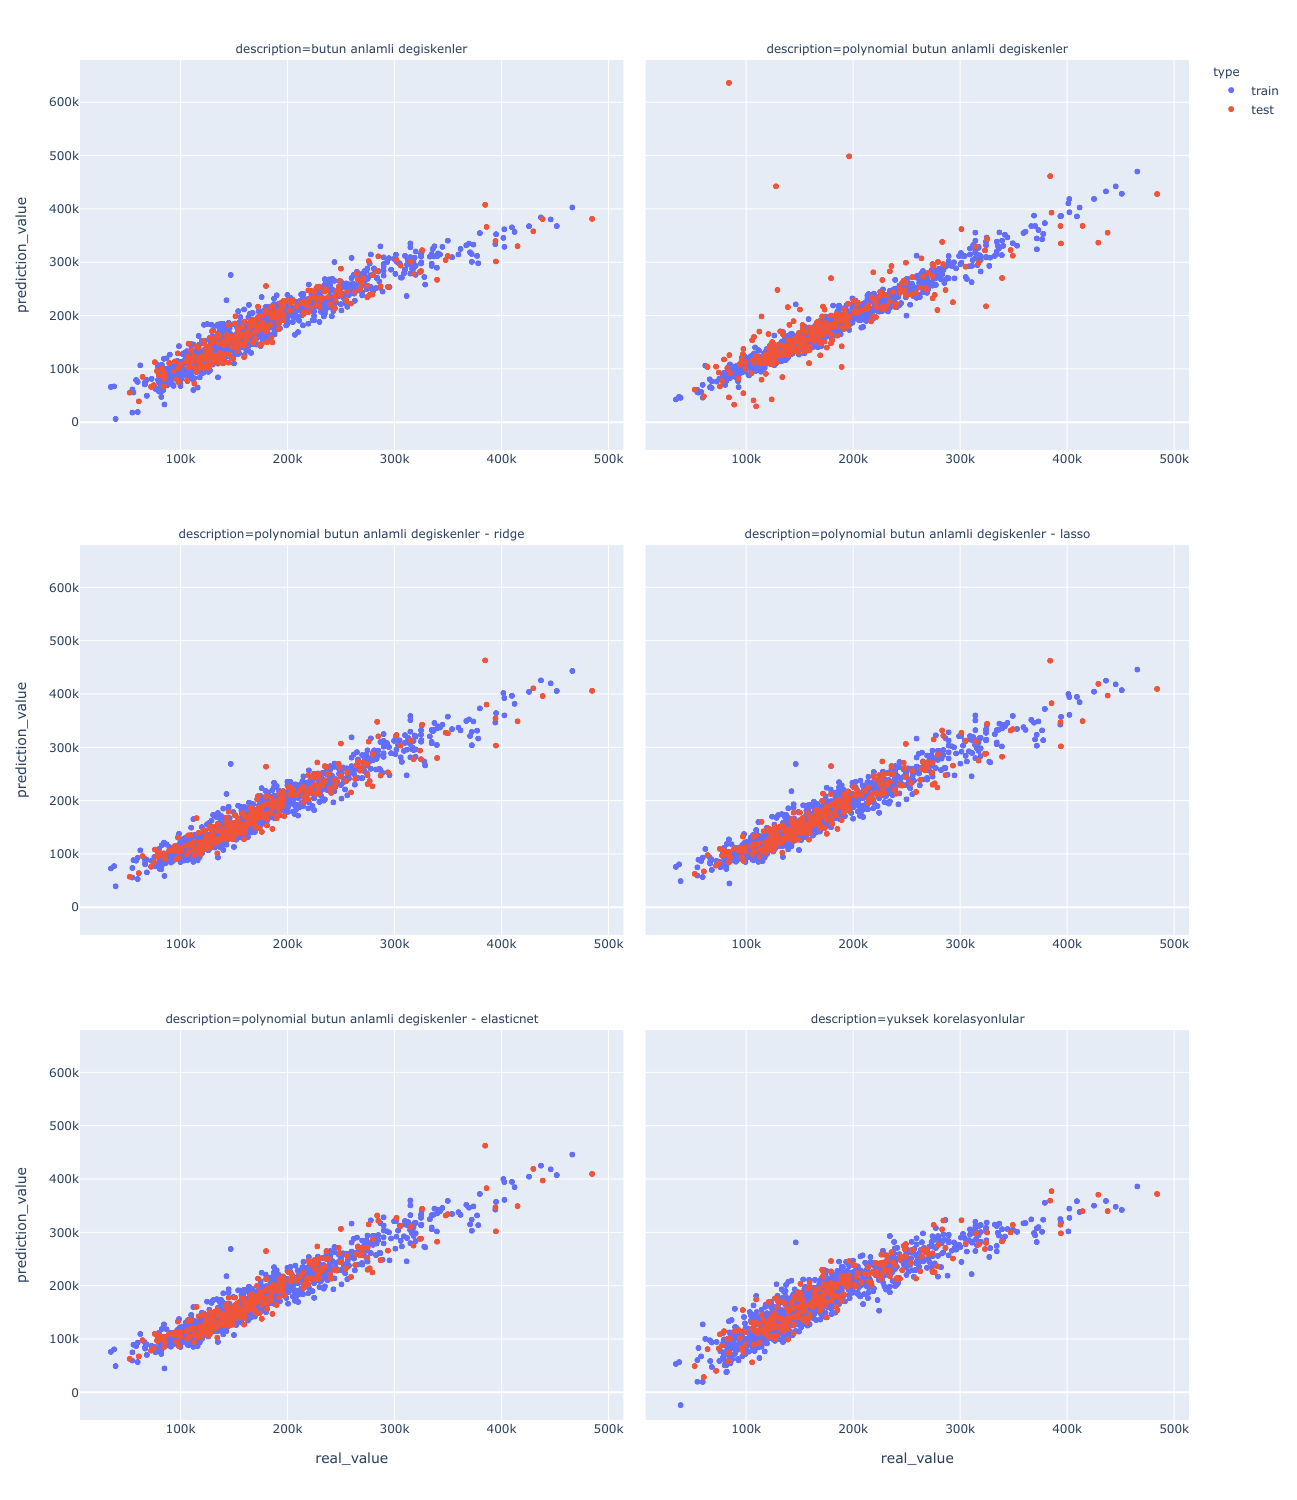

In [23]:
# model sonuclari
display(results_df)
fig = px.scatter(predict_df, x="real_value", y="prediction_value",  
                 facet_col="description", facet_col_wrap=2, color='type')
# yukseklik ve genislik
fig.update_layout(height=1500, width=1300)
# x axis ini paylasmama ve tick label gosterimi icin
fig.update_xaxes(matches=None, showticklabels=True)
fig.show()